In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1913).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (209).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1381).jpg


In [2]:
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from keras.preprocessing import image
from PIL import Image
import torch
from torch import nn
import matplotlib.pyplot as plt

2024-04-21 11:27:53.931662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 11:27:53.931805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 11:27:54.059587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

In [4]:
image = Image.open('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (10).jpg').convert('RGB') 

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

tensor = transform(image).unsqueeze(0).requires_grad_()

In [5]:
model = models.alexnet(weights=True)

# # Get the number of input features for the last fully connected layer
num_features = model.classifier[1].in_features

# # Modify the last fully connected layer
model.classifier[1] = nn.Linear(num_features, 4096)
model.classifier[4] = nn.Linear(4096, 1024)
model.classifier[6] = nn.Linear(1024, 1)

# # Print the model
print('AlexNet Architecture:\n', '-'*60, '\n', model, '\n', '-'*60)
alexnet = model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 166MB/s]  


AlexNet Architecture:
 ------------------------------------------------------------ 
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

In [8]:
# # # Freeze the weights of the initial layers
for param in alexnet.features.parameters():
    param.requires_grad = False

# # Get the number of input features for the last fully connected layer
num_features = alexnet.classifier[1].in_features

# # Modify the last fully connected layer
alexnet.classifier[1] = nn.Linear(num_features, 4096)
alexnet.classifier[4] = nn.Linear(4096, 4096)
alexnet.classifier[6] = nn.Linear(4096, 1000)

# # Unfreeze the weights of the last 5 layers
for param in alexnet.classifier[1:].parameters():
    param.requires_grad = True

# # Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5

alexnet = alexnet.to(device)

# Train the model
for epoch in range(num_epochs):
    # Training loop
    correct = 0
    total = 0
    i=0
    for images, labels in train_loader:
        # Forward pass
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        i+=1
#         print('a')
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}: Validation Accuracy = {accuracy}%')
    print(total,predicted,i)
    
#     # Validation loop
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in val_loader:
#             outputs = alexnet(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         accuracy = 100 * correct / total
#         print(f'Epoch {epoch+1}: Validation Accuracy = {accuracy}%')


Epoch 1: Validation Accuracy = 79.96946810220152%
12446 tensor([0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 0, 1, 3, 1, 3, 1, 0, 2, 3, 1, 1, 3, 0, 1,
        2, 3, 1, 0, 0, 1], device='cuda:0') 389
Epoch 2: Validation Accuracy = 93.78916921099149%
12446 tensor([1, 1, 1, 1, 0, 3, 0, 1, 3, 1, 3, 1, 0, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3,
        3, 1, 1, 0, 3, 1], device='cuda:0') 389
Epoch 3: Validation Accuracy = 96.30403342439338%
12446 tensor([0, 3, 3, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 3, 1, 3, 1, 3,
        3, 0, 0, 1, 1, 1], device='cuda:0') 389
Epoch 4: Validation Accuracy = 97.47710107665114%
12446 tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 3, 0, 2, 3, 1, 0, 2, 1, 0, 1, 1, 0, 2,
        0, 1, 1, 0, 0, 3], device='cuda:0') 389
Epoch 5: Validation Accuracy = 97.91901012373454%
12446 tensor([1, 0, 1, 1, 0, 1, 3, 3, 0, 1, 0, 2, 1, 3, 2, 3, 1, 0, 1, 1, 0, 2, 1, 0,
        3, 1, 0, 0, 0, 3], device='cuda:0') 389


In [9]:
class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None # store R0
        self.activation_maps = []  # store f1, f2, ... 
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0] 

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop() 
            # for the forward pass, after the ReLU operation, 
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1 
            
            # grad_out[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)


        # AlexNet model 
        modules = list(self.model.features.named_children())

        # travese the modules，register forward hook & backward hook
        # for the ReLU
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # register backward hook for the first conv layer
        first_layer = modules[0][1] 
        first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
        
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        model_output.backward(grad_target_map.to(device))
        
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result

In [10]:
image = Image.open('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1).jpg').convert('RGB') 

tensor = transform(image).unsqueeze(0).requires_grad_()

alexnet(tensor.to(device))

tensor([[ 9.9302e+00,  1.0355e+01,  7.4194e+00,  1.5269e+01,  1.2500e-01,
         -9.1453e-02, -2.4371e-01,  3.3344e-01, -2.6963e-01,  3.8968e-01,
          7.6430e-02, -5.3532e-01, -7.9202e-01,  2.7838e-01, -4.0396e-01,
          1.3072e-01, -6.6903e-02,  1.5154e-01,  2.1518e-01,  5.1545e-01,
          2.6912e-01,  2.0015e-02, -6.4778e-01, -1.7302e-01, -8.0852e-02,
          2.1480e-01, -1.0699e-02,  1.8865e-01, -4.0599e-01, -1.0414e+00,
          2.4565e-01, -2.5758e-01, -2.0166e-01, -7.6510e-02,  1.9799e-01,
         -1.7818e-02,  1.6067e-01, -1.6010e-01, -2.3747e-01, -2.4864e-01,
         -3.5156e-01, -1.6677e-01,  4.2964e-01,  4.2150e-01,  1.9152e-01,
          2.0907e-01, -2.8202e-02, -3.4588e-02, -3.7099e-02,  5.7873e-01,
         -5.9679e-02, -2.7799e-01, -5.2158e-01, -6.4632e-02, -5.4147e-01,
         -2.5943e-01,  1.0004e-01,  4.8838e-01,  5.0387e-02, -4.9174e-01,
         -2.0061e-01, -1.8763e-01,  3.5770e-01, -5.4120e-01, -5.2475e-01,
          4.4874e-01, -2.8669e-02,  4.

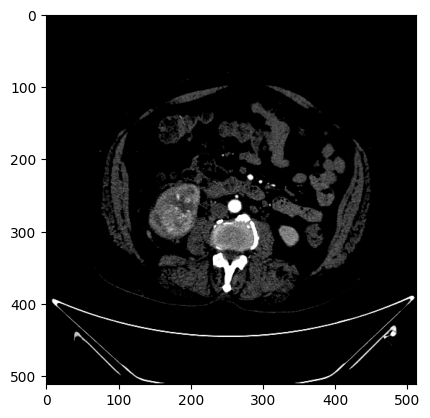

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


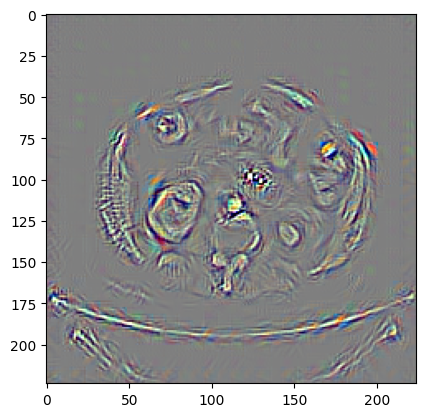

In [11]:
guided_bp = Guided_backprop(alexnet)
# plt.imshow(tensor.cpu().detach().numpy())
plt.imshow((image))
plt.show()

tensor = tensor.to(device)
result = guided_bp.visualize(tensor, None)
result = normalize(result).cpu().numpy()
plt.imshow(result)
plt.show()